<img src="img/logo.png">

<p style="text-align: justify;">
LendingClub is a pioneering financial services company, headquartered in San Francisco, California. It achieved several notable industry firsts, such as registering its offerings as securities with the Securities and Exchange Commission (SEC) and introducing a secondary market for loan trading. At its zenith, LendingClub was the world's largest peer-to-peer lending platform, facilitating loans ranging from 1,000 to 40,000 USD, typically with a three-year term. Investors could peruse and select loans based on borrower details, loan grade, and purpose, earning interest on their investments. LendingClub generated revenue through origination fees from borrowers and service fees from investors.
</p>
<p style="text-align: justify;">
Additionally, LendingClub ventured into traditional direct-to-consumer lending, including auto refinance transactions, through WebBank. In 2014, it conducted the largest technology IPO in the United States, raising $1 billion. However, LendingClub faced challenges in 2016, including difficulty attracting investors, a loan scandal, and concerns regarding CEO Renaud Laplanche's disclosures, resulting in a significant drop in its stock price and Laplanche's resignation.
</p>
<p style="text-align: justify;">
In 2020, LendingClub acquired Radius Bank and decided to discontinue its peer-to-peer lending platform. Existing account holders would continue to accrue interest on outstanding notes, but no new loans were available for individual investors, and the secondary marketplace for selling existing loans was closed.
</p>

The dataset contains data related to accepted loans from LendingClub, covering the period from 2007 to the fourth quarter of 2018.

In [75]:
#!pip install pyspark

# Importations

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, regexp_replace
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import lit
from pyspark.sql import DataFrame
from pyspark.ml.stat import Correlation
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import abs as pyspark_abs, mean, sqrt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Fonctions personnelles
from mylib.fonction_distribution_stats import plot_distribution_stats
from mylib.fonction_normality import calculate_normality

# Versions
import sys
import pyspark
print("Version de Python:", sys.version)
print("Version numpy : " + np.__version__)
print("Version pandas : " + pd.__version__)
print("Version de seaborn:", sns.__version__)
print("Version de pyspark:", pyspark.__version__)

Version de Python: 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
Version numpy : 1.23.5
Version pandas : 1.4.4
Version de seaborn: 0.12.1
Version de pyspark: 3.5.0


# Lancement de Spark

In [77]:
spark = SparkSession.builder.appName("lending-club").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
#spark.conf.set("spark.sql.repl.eagerEval.enabled", False)

# Chargement des données

In [78]:
file = 'src/accepted.csv'

In [79]:
selected_columns = [
    "id",
    "purpose",
    "term",
    "addr_state",
    "annual_inc",
    "application_type",
    "grade",
    "home_ownership",
    "dti",
    "delinq_amnt",
    "installment",
    "int_rate",
    "loan_amnt",
    "loan_status",
    "total_rec_late_fee",
    'recoveries',
    'collection_recovery_fee']

data = spark.read.csv(file, header=True, inferSchema=True).select(selected_columns)
data.show()

+--------+------------------+----------+----------+----------+----------------+-----+--------------+-----+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
|      id|           purpose|      term|addr_state|annual_inc|application_type|grade|home_ownership|  dti|delinq_amnt|installment|int_rate|loan_amnt|loan_status|total_rec_late_fee|recoveries|collection_recovery_fee|
+--------+------------------+----------+----------+----------+----------------+-----+--------------+-----+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
|68407277|debt_consolidation| 36 months|        PA|   55000.0|      Individual|    C|      MORTGAGE| 5.91|        0.0|     123.03|   13.99|   3600.0| Fully Paid|               0.0|       0.0|                    0.0|
|68355089|    small_business| 36 months|        SD|   65000.0|      Individual|    C|      MORTGAGE|16.06|        0.0|     820.28|   11.

# Dimensions

In [80]:
num_rows = data.count()  # Nombre de lignes
num_columns = len(data.columns)  # Nombre de colonnes
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 67611
Number of columns: 17


# Type des données

In [81]:
data_dtypes = data.dtypes

# Conversion en DataFrame pandas
df_dtypes = pd.DataFrame(data_dtypes, columns=["Colonne", "Type"])
print(df_dtypes)

                    Colonne    Type
0                        id     int
1                   purpose  string
2                      term  string
3                addr_state  string
4                annual_inc  double
5          application_type  string
6                     grade  string
7            home_ownership  string
8                       dti  double
9               delinq_amnt  double
10              installment  double
11                 int_rate  double
12                loan_amnt  double
13              loan_status  string
14       total_rec_late_fee  double
15               recoveries  double
16  collection_recovery_fee  double


# Doublons

In [82]:
# Supprimer les doublons
data_no_duplicates = data.dropDuplicates()

# Vérifier le nombre de doublons
num_duplicates = data.count() - data_no_duplicates.count()
print("Nombre de doublons :", num_duplicates)

# Obtenir les lignes dupliquées
duplicate_rows = data.exceptAll(data_no_duplicates)
duplicate_rows.show()

Nombre de doublons : 0


+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
| id|purpose|term|addr_state|annual_inc|application_type|grade|home_ownership|dti|delinq_amnt|installment|int_rate|loan_amnt|loan_status|total_rec_late_fee|recoveries|collection_recovery_fee|
+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+



# Valeurs manquantes

In [83]:
# Affichage du nombre de NaN
missing_counts = data.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])

# Vérifier le nombre de valeurs manquantes
total_missing_values = sum(missing_counts.collect()[0])
print("Nombre de valeurs manquantes :", total_missing_values)

# Obtenir les lignes avec valeurs manquantes
missing_counts.show()

Nombre de valeurs manquantes : 14
+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
| id|purpose|term|addr_state|annual_inc|application_type|grade|home_ownership|dti|delinq_amnt|installment|int_rate|loan_amnt|loan_status|total_rec_late_fee|recoveries|collection_recovery_fee|
+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
|  0|      1|   0|         1|         1|               1|    1|             1|  3|          1|          0|       0|        0|          1|                 1|         1|                      1|
+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+



In [84]:
# Vérification des observations avec NaN

# Initialiser un DataFrame vide pour stocker les lignes avec NaN
lignes_avec_nan = spark.createDataFrame([], data.schema)

# Utiliser une boucle pour vérifier les NaN dans chaque colonne
for colonne in data.columns:
    lignes_avec_nan_colonne = data.filter((isnan(col(colonne))) | (col(colonne).isNull()))
    lignes_avec_nan = lignes_avec_nan.union(lignes_avec_nan_colonne)
lignes_sans_nan = lignes_avec_nan.dropDuplicates()
print("Nombre d'ID impactés :", lignes_sans_nan.count())
lignes_sans_nan.show()

Nombre d'ID impactés : 3


+--------+------------------+----------+----------+----------+----------------+-----+--------------+----+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
|      id|           purpose|      term|addr_state|annual_inc|application_type|grade|home_ownership| dti|delinq_amnt|installment|int_rate|loan_amnt|loan_status|total_rec_late_fee|recoveries|collection_recovery_fee|
+--------+------------------+----------+----------+----------+----------------+-----+--------------+----+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
|63898447|              NULL| 36 months|      NULL|      NULL|            NULL| NULL|          NULL|NULL|       NULL|       62.0|    7.89|  20000.0|       NULL|              NULL|      NULL|                   NULL|
|66415476|debt_consolidation| 36 months|        TX|       0.0|       Joint App|    D|      MORTGAGE|NULL|        0.0|     712.96|   16.99|  

In [85]:
# Suppression des NaN
data = data.na.drop()
missing_counts = data.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])

total_missing_values = sum(missing_counts.collect()[0])
print("Nombre de valeurs manquantes :", total_missing_values)

missing_counts.show()

Nombre de valeurs manquantes : 0
+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
| id|purpose|term|addr_state|annual_inc|application_type|grade|home_ownership|dti|delinq_amnt|installment|int_rate|loan_amnt|loan_status|total_rec_late_fee|recoveries|collection_recovery_fee|
+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
|  0|      0|   0|         0|         0|               0|    0|             0|  0|          0|          0|       0|        0|          0|                 0|         0|                      0|
+---+-------+----+----------+----------+----------------+-----+--------------+---+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+



# Statistiques descriptives

In [86]:
# Colonnes numériques
col_num = [colonne for colonne in data.columns if isinstance(data.schema[colonne].dataType, DoubleType)]
print(col_num)

['annual_inc', 'dti', 'delinq_amnt', 'installment', 'int_rate', 'loan_amnt', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee']


In [87]:
# Statistiques les colonnes numériques
data[col_num].summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

+-------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------------+
|summary|       annual_inc|               dti|      delinq_amnt|      installment|          int_rate|        loan_amnt|total_rec_late_fee|       recoveries|collection_recovery_fee|
+-------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------------+
|  count|            67608|             67608|            67608|            67608|             67608|            67608|             67608|            67608|                  67608|
|   mean|78903.33141506923|19.384009140930083|14.19209265175719|433.8601356348392|12.230579221394443|15036.06488877056|2.1826800680867167|228.0492438764644|      40.63955493578945|
| stddev|93309.65933883552| 9.677101399070814|789.6772685759156|246.3722208701744|4.17392508354

# Vérification des valeurs catégoriques uniques

In [88]:
data.select("purpose").distinct().show()
data.select("grade").distinct().show()
data.select("term").distinct().show()
data.select("loan_status").distinct().show()
data.select("home_ownership").distinct().show()
data.select("application_type").distinct().show()
data.select("addr_state").distinct().show(n=49) #data.select("addr_state").distinct().count() = 49

+------------------+
|           purpose|
+------------------+
|             other|
|    small_business|
|debt_consolidation|
|       credit_card|
|            moving|
|          vacation|
|  renewable_energy|
|             house|
|               car|
|    major_purchase|
|           medical|
|  home_improvement|
+------------------+

+-----+
|grade|
+-----+
|    F|
|    E|
|    B|
|    D|
|    C|
|    A|
|    G|
+-----+

+----------+
|      term|
+----------+
| 36 months|
| 60 months|
+----------+

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
| Late (16-30 days)|
|           Default|
+------------------+

+--------------+
|home_ownership|
+--------------+
|           OWN|
|          RENT|
|      MORTGAGE|
|           ANY|
+--------------+

+----------------+
|application_type|
+----------------+
|       Joint App|
|      Individual|
+----------------+

+----------

# Distribution des variables numériques

## Histogrammes

Pourcentage d'observations avec des revenus inférieurs ou égaux à 150 000 USD : 94.41%
Pourcentage d'observations avec des revenus supérieurs ou égaux à 150 000 USD et inférieurs à 400 000 USD : 6.44%
------------



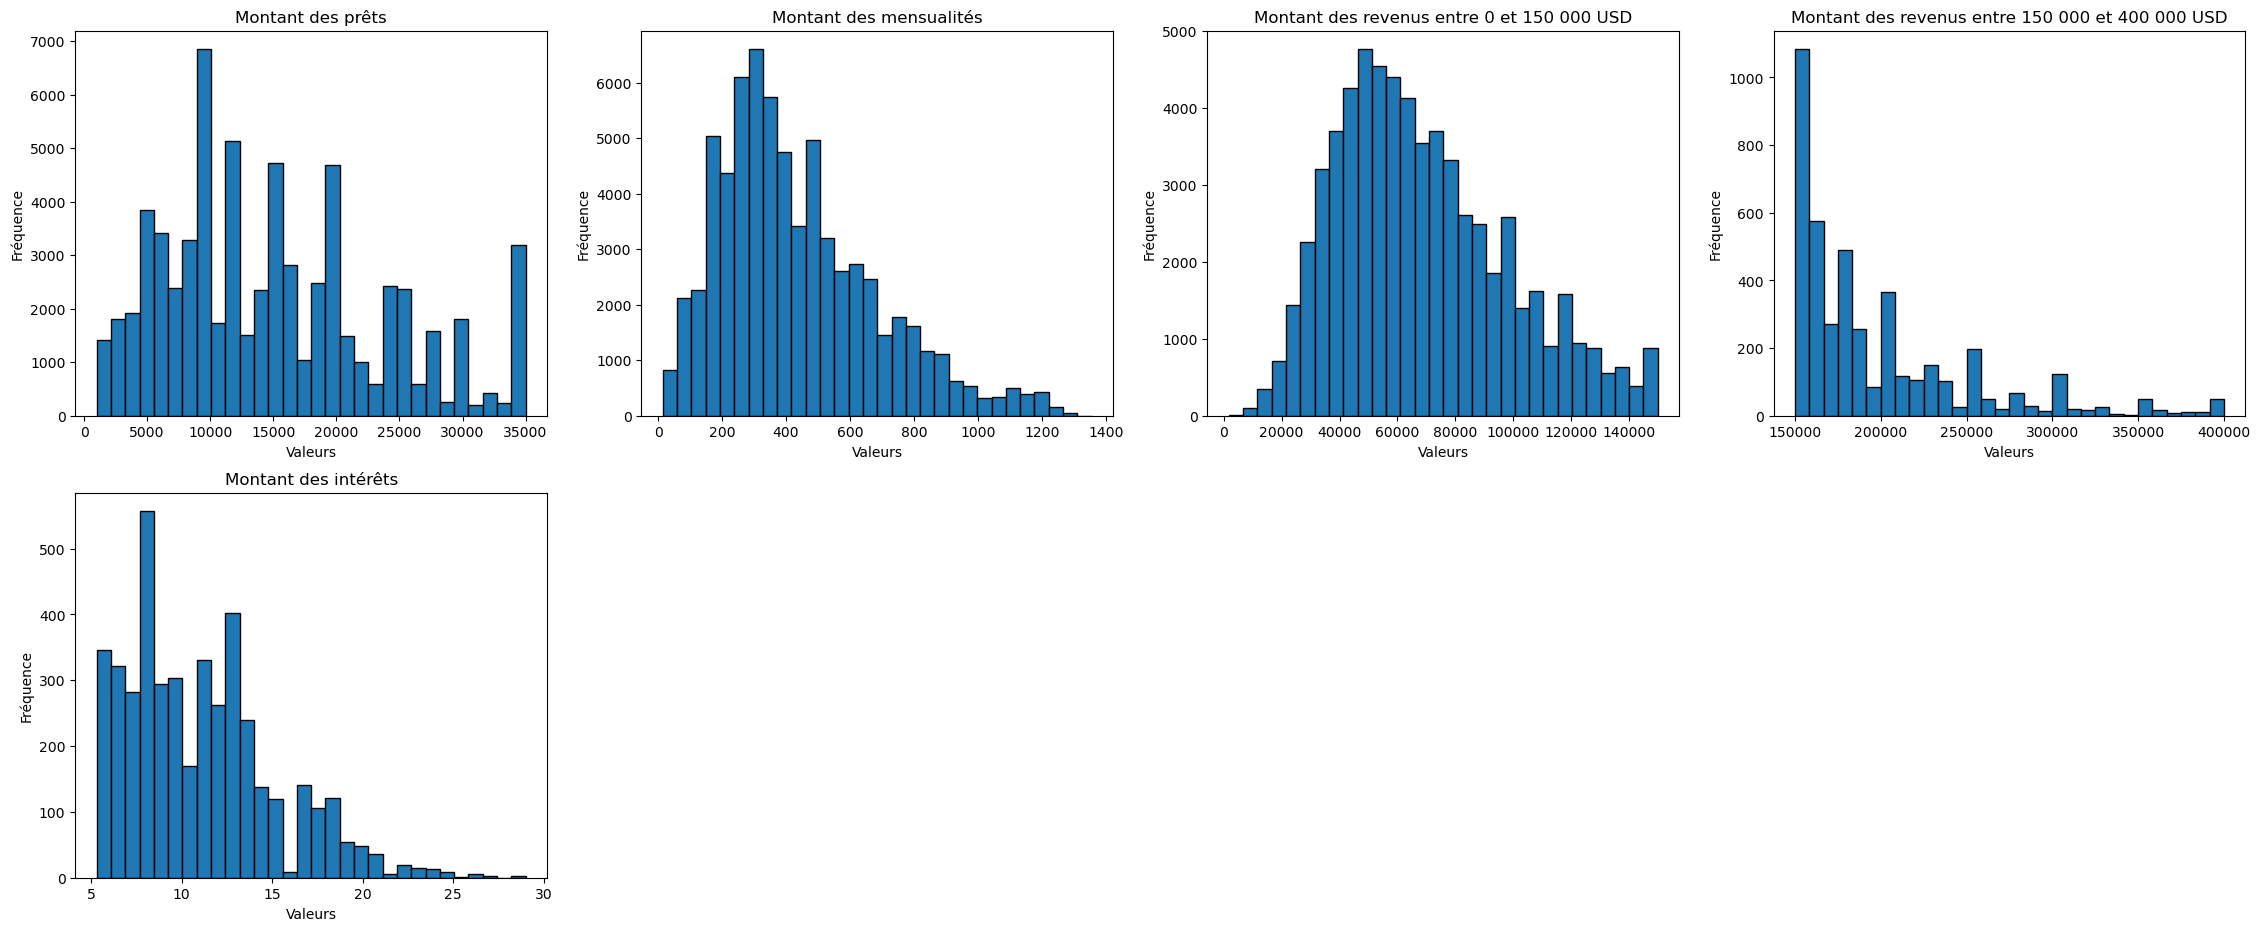

In [89]:
# Conversion du DataFrame Spark en DataFrame Pandas
pandas_df = data.toPandas()

# Créer une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(2, 4, figsize=(28, 11))

# Premier sous-graphique : Montant des prêts
axes[0, 0].hist(pandas_df["loan_amnt"], bins=30, edgecolor='k')
axes[0, 0].set_xlabel("Valeurs")
axes[0, 0].set_ylabel("Fréquence")
axes[0, 0].set_title("Montant des prêts")

# Deuxième sous-graphique : Montant des mensualités
axes[0, 1].hist(pandas_df["installment"], bins=30, edgecolor='k')
axes[0, 1].set_xlabel("Valeurs")
axes[0, 1].set_ylabel("Fréquence")
axes[0, 1].set_title("Montant des mensualités")

# Filtrage des revenus entre 0 et 100 000 USD
filtered_df = pandas_df.loc[pandas_df['annual_inc'] <= 150000]
percentage_below_100k = (len(filtered_df) / len(pandas_df)) * 100
print(f"Pourcentage d'observations avec des revenus inférieurs ou égaux à 150 000 USD : {percentage_below_100k:.2f}%")

# Troisième sous-graphique : Montant des revenus
axes[0, 2].hist(filtered_df["annual_inc"], bins=30, edgecolor='k')
axes[0, 2].set_xlabel("Valeurs")
axes[0, 2].set_ylabel("Fréquence")
axes[0, 2].set_title("Montant des revenus entre 0 et 150 000 USD")

# Filtrage des revenus entre 100 000 et 400 000 USD
filtered_df = pandas_df.loc[(pandas_df['annual_inc'] >= 150000) & (pandas_df['annual_inc'] <= 400000)]
percentage_above_100k = (len(filtered_df) / len(pandas_df)) * 100
print(f"Pourcentage d'observations avec des revenus supérieurs ou égaux à 150 000 USD et inférieurs à 400 000 USD : {percentage_above_100k:.2f}%\n------------\n")

# Quatrième sous-graphique : Montant des revenus
axes[0, 3].hist(filtered_df["annual_inc"], bins=30, edgecolor='k')
axes[0, 3].set_xlabel("Valeurs")
axes[0, 3].set_ylabel("Fréquence")
axes[0, 3].set_title("Montant des revenus entre 150 000 et 400 000 USD")

# Quatrième sous-graphique : Montant des revenus
axes[1, 0].hist(filtered_df["int_rate"], bins=30, edgecolor='k')
axes[1, 0].set_xlabel("Valeurs")
axes[1, 0].set_ylabel("Fréquence")
axes[1, 0].set_title("Montant des intérêts")

# Supprimer les trois derniers graphiques vides
for i in range(1, 4):
    fig.delaxes(axes[1, i])

# Afficher la figure
plt.show()

## Tests de normalité

In [90]:
# Colonnes numériques
#selected_columns = ['annual_inc', 'installment', 'int_rate', 'loan_amnt', 'total_rec_late_fee', 'dti', 'delinq_amnt']

# Supression des NaNs pour le test
test = pandas_df[col_num]#.dropna()

# Calcul de la normalité
calculate_normality(test)

--------------------------------------------------
annual_inc :
Skew: 52.35   The distribution is highly skewed
Kurtosis: 4246.66   The distribution is heavy-tailed (positive), sometimes called leptokurtic distribution 
---
Tests statistiques :
D'Agostino-Pearson: Statistic=216269.8001, p=0.0000 - Sample does not look Gaussian (reject H0)
Shapiro-Wilk: Statistic=0.2610, p=0.0000 - Sample does not look Gaussian (reject H0)
--------------------------------------------------
dti :
Skew: 16.36   The distribution is highly skewed
Kurtosis: 1581.69   The distribution is heavy-tailed (positive), sometimes called leptokurtic distribution 
---
Tests statistiques :
D'Agostino-Pearson: Statistic=139400.5359, p=0.0000 - Sample does not look Gaussian (reject H0)
Shapiro-Wilk: Statistic=0.8297, p=0.0000 - Sample does not look Gaussian (reject H0)
--------------------------------------------------
delinq_amnt :
Skew: 79.39   The distribution is highly skewed
Kurtosis: 6845.61   The distribution is he

# Corrélations

## DenseMatrix

In [91]:
# Création de la colonne de caractéristiques (features)
assembler = VectorAssembler(inputCols=col_num, outputCol="features")
data_corr = assembler.transform(data)

# Calcul de la matrice de corrélation
corr_matrix = Correlation.corr(data_corr, "features", method="spearman")

# Matrice de corrélation sous forme de DataFrame
corr_df = corr_matrix.select("spearman(features)").first()[0]

# Matrice de corrélation
print(corr_df)

DenseMatrix([[ 1.00000000e+00, -2.19243580e-01,  1.64955619e-02,
               4.78473675e-01, -1.61557325e-01,  5.00061080e-01,
               1.72582692e-02, -2.20286884e-02, -2.22620623e-02],
             [-2.19243580e-01,  1.00000000e+00,  6.10381250e-03,
               2.99075991e-02,  2.11777513e-01,  3.88438318e-02,
               7.47639778e-03,  7.12924363e-02,  7.15346200e-02],
             [ 1.64955619e-02,  6.10381250e-03,  1.00000000e+00,
               1.57376103e-03,  2.22672291e-02,  1.58480039e-04,
               7.68825483e-03,  3.58620918e-03,  3.63085400e-03],
             [ 4.78473675e-01,  2.99075991e-02,  1.57376103e-03,
               1.00000000e+00,  9.97701141e-02,  9.59724983e-01,
               2.57303123e-02,  6.07046660e-02,  6.06612962e-02],
             [-1.61557325e-01,  2.11777513e-01,  2.22672291e-02,
               9.97701141e-02,  1.00000000e+00,  1.22881479e-01,
               9.60039075e-02,  2.21691957e-01,  2.22084448e-01],
             [ 5.000

## Affichage sous forme de heatmap

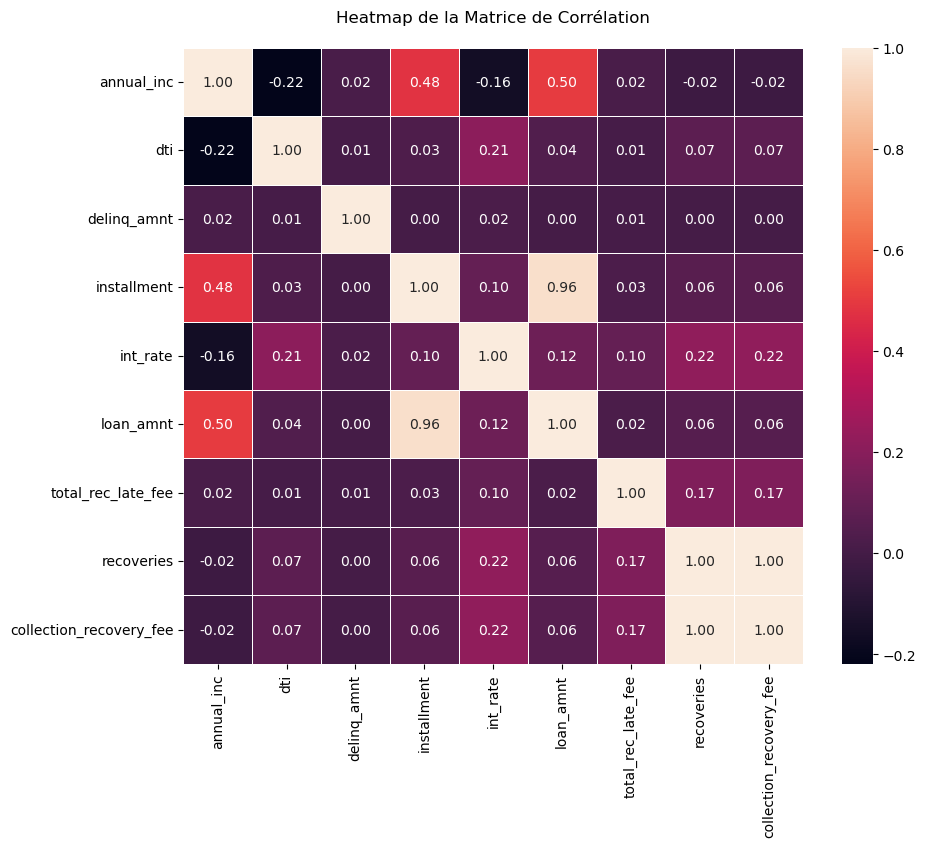

In [92]:
# Conversion de la matrice de corrélation en un DataFrame Pandas
corr_matrix_pd = pd.DataFrame(corr_df.toArray(), columns=col_num, index=col_num)

# Affichage sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_pd, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Heatmap de la Matrice de Corrélation\n")
plt.show()

# Visualisations

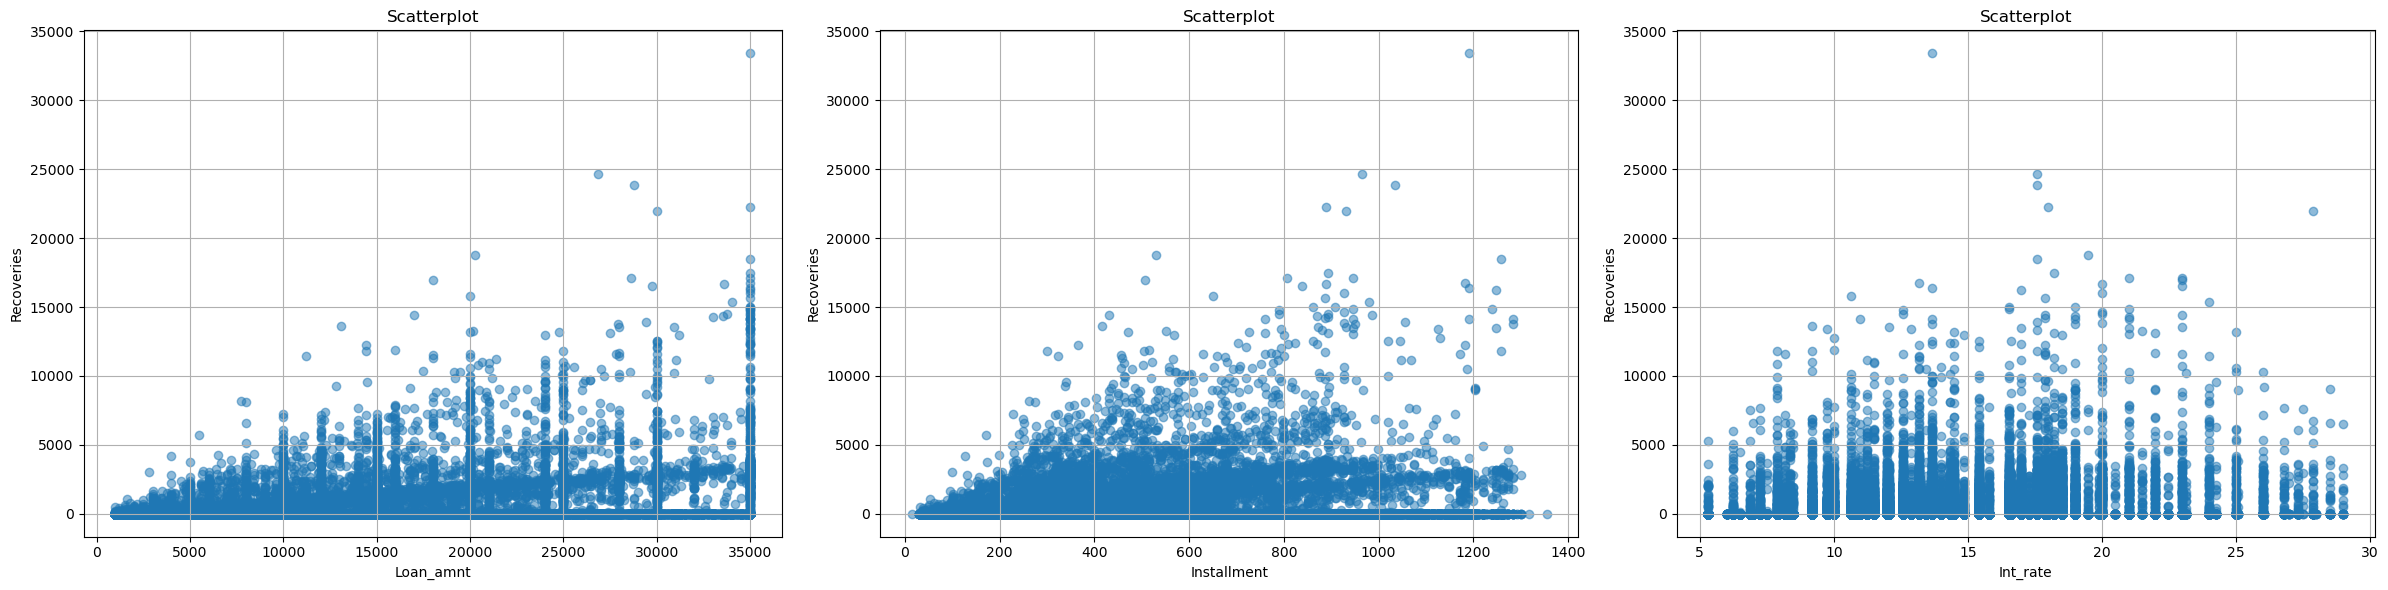

In [93]:
column_pairs = [("loan_amnt", "recoveries"), ("installment", "recoveries"), ("int_rate", "recoveries")]
fig, axs = plt.subplots(1, len(column_pairs), figsize=(24, 6))

for i, (x_column, y_column) in enumerate(column_pairs):
    # Sélectionner les données Spark pour les colonnes x et y
    x_data = data.select(x_column).rdd.flatMap(lambda x: x)
    y_data = data.select(y_column).rdd.flatMap(lambda x: x)
    
    # Collectez les données Spark en tant que listes Python
    x_values = x_data.collect()
    y_values = y_data.collect()
    
    # Créez un scatterplot pour la paire de colonnes actuelle
    axs[i].scatter(x_values, y_values, alpha=0.5)
    axs[i].set_title(f"Scatterplot")
    axs[i].set_xlabel(x_column.capitalize())
    axs[i].set_ylabel(y_column.capitalize())
    axs[i].grid(True)

plt.tight_layout()
plt.show()

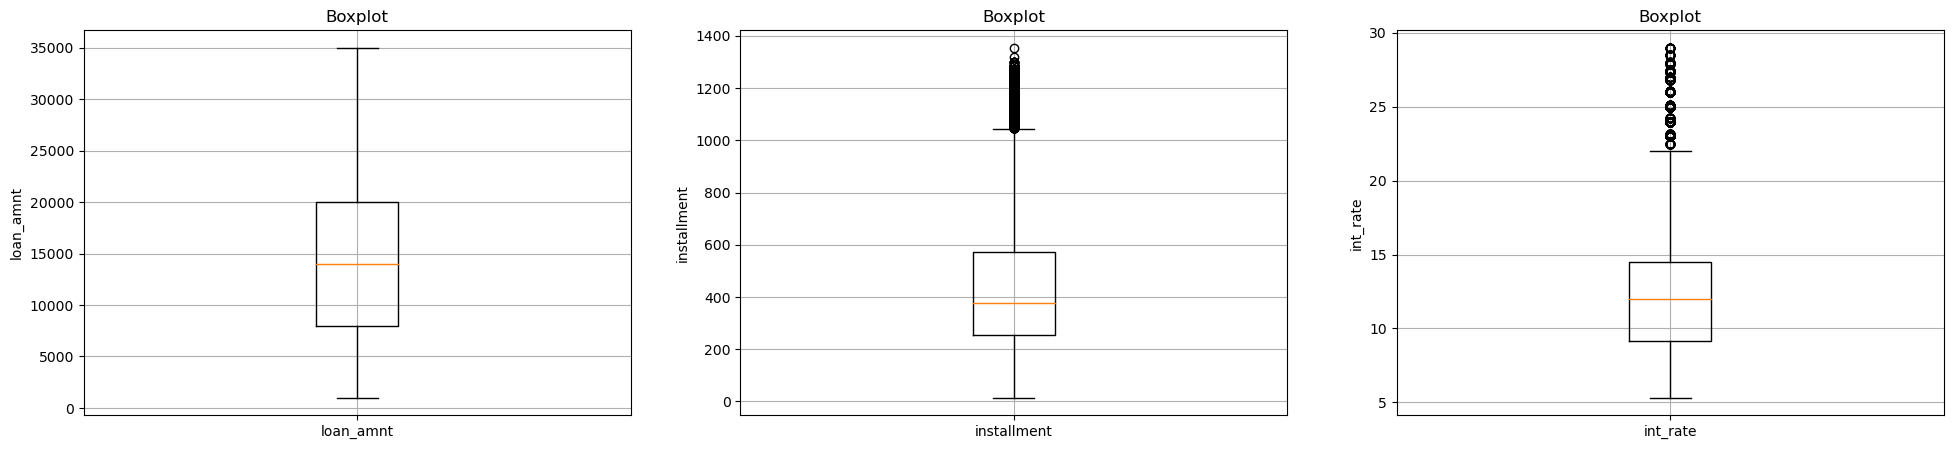

In [94]:
# Création des boxplots
fig, axs = plt.subplots(1, 3, figsize=(24, 5))
columns = ["loan_amnt", "installment", "int_rate"]
for i, col in enumerate(columns):
    x_data = data.select(col).rdd.flatMap(lambda x: x)
    x_values = x_data.collect()
    axs[i].boxplot([x_values], labels=[col])
    axs[i].set_title("Boxplot")
    axs[i].set_ylabel(col)
    axs[i].grid(True)
plt.show()

# Aperçu des variables catégoriques

## 'purpose'

In [96]:
df_count = data.groupBy('purpose').count()
df_count.orderBy(F.desc("count")).show() # tri du DataFrame du plus élevé au plus bas

+------------------+-----+
|           purpose|count|
+------------------+-----+
|debt_consolidation|38356|
|       credit_card|17024|
|  home_improvement| 4210|
|             other| 3673|
|    major_purchase| 1381|
|           medical|  757|
|    small_business|  601|
|               car|  599|
|            moving|  381|
|          vacation|  363|
|             house|  229|
|  renewable_energy|   34|
+------------------+-----+



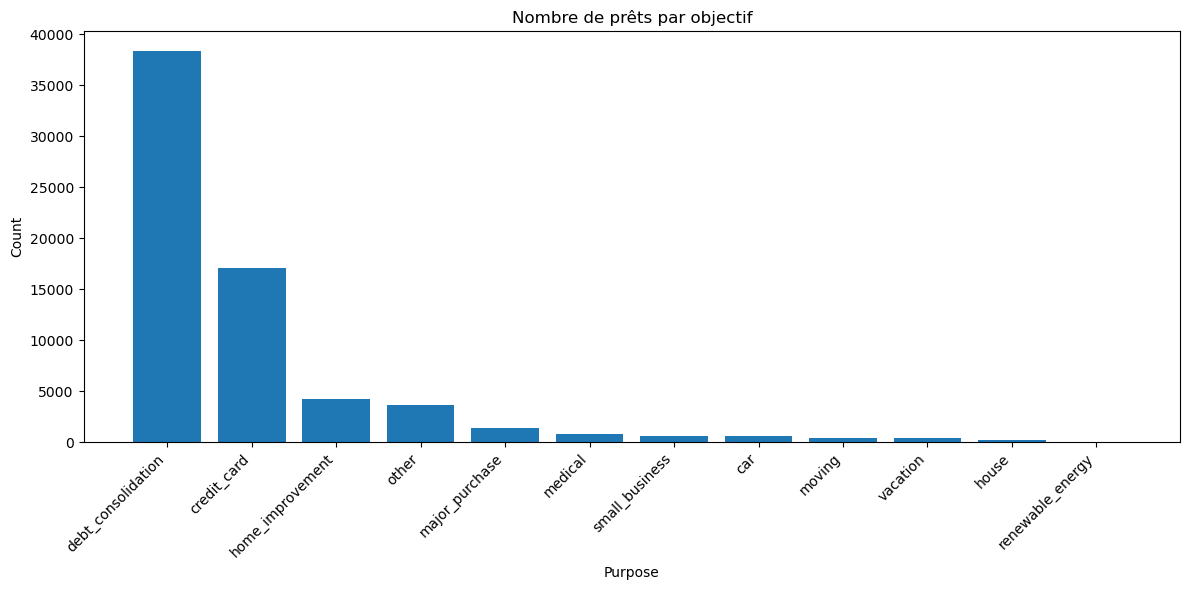

In [97]:
# Convertir le DataFrame Spark en DataFrame Pandas
df_pandas = df_count.toPandas()

# Trier le DataFrame Pandas par ordre décroissant
df_pandas = df_pandas.sort_values(by='count', ascending=False)

# Créer le bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_pandas['purpose'], df_pandas['count'])
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.title('Nombre de prêts par objectif')
plt.xticks(rotation=45, ha='right')

# Afficher le bar chart
plt.tight_layout()
plt.show()

## 'addr_state'

In [98]:
df_count = data.groupBy('addr_state').count()
df_count.orderBy(F.desc("count")).show(n=49)

+----------+-----+
|addr_state|count|
+----------+-----+
|        CA| 9021|
|        TX| 5543|
|        NY| 5476|
|        FL| 4813|
|        IL| 2660|
|        NJ| 2464|
|        PA| 2375|
|        GA| 2332|
|        OH| 2322|
|        VA| 2041|
|        NC| 1922|
|        MI| 1826|
|        MD| 1641|
|        AZ| 1609|
|        MA| 1570|
|        CO| 1349|
|        WA| 1344|
|        MN| 1212|
|        TN| 1205|
|        IN| 1184|
|        MO| 1091|
|        CT| 1010|
|        WI|  885|
|        NV|  871|
|        SC|  852|
|        AL|  844|
|        LA|  748|
|        OR|  747|
|        KY|  702|
|        OK|  588|
|        KS|  579|
|        AR|  513|
|        UT|  426|
|        MS|  390|
|        NM|  379|
|        NH|  344|
|        ME|  320|
|        NE|  313|
|        HI|  311|
|        RI|  295|
|        WV|  238|
|        DE|  195|
|        ND|  180|
|        MT|  179|
|        DC|  161|
|        VT|  147|
|        AK|  139|
|        SD|  132|
|        WY|  120|
+----------+

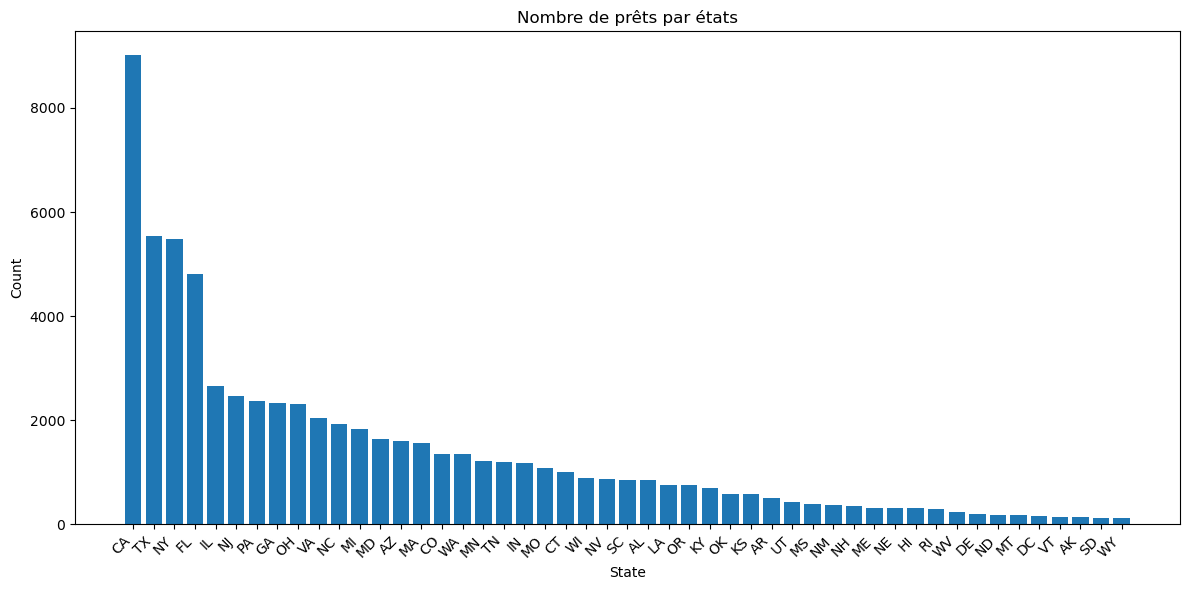

In [99]:
# Convertir le DataFrame Spark en DataFrame Pandas
df_pandas = df_count.toPandas()

# Trier le DataFrame Pandas par ordre décroissant
df_pandas = df_pandas.sort_values(by='count', ascending=False)

# Créer le bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_pandas['addr_state'], df_pandas['count'])
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Nombre de prêts par états')
plt.xticks(rotation=45, ha='right')

# Afficher le bar chart
plt.tight_layout()
plt.show()

## 'home_ownership'

In [100]:
df_count = data.groupBy('home_ownership').count()
df_count.orderBy(F.desc("count")).show()

+--------------+-----+
|home_ownership|count|
+--------------+-----+
|      MORTGAGE|33461|
|          RENT|26419|
|           OWN| 7727|
|           ANY|    1|
+--------------+-----+



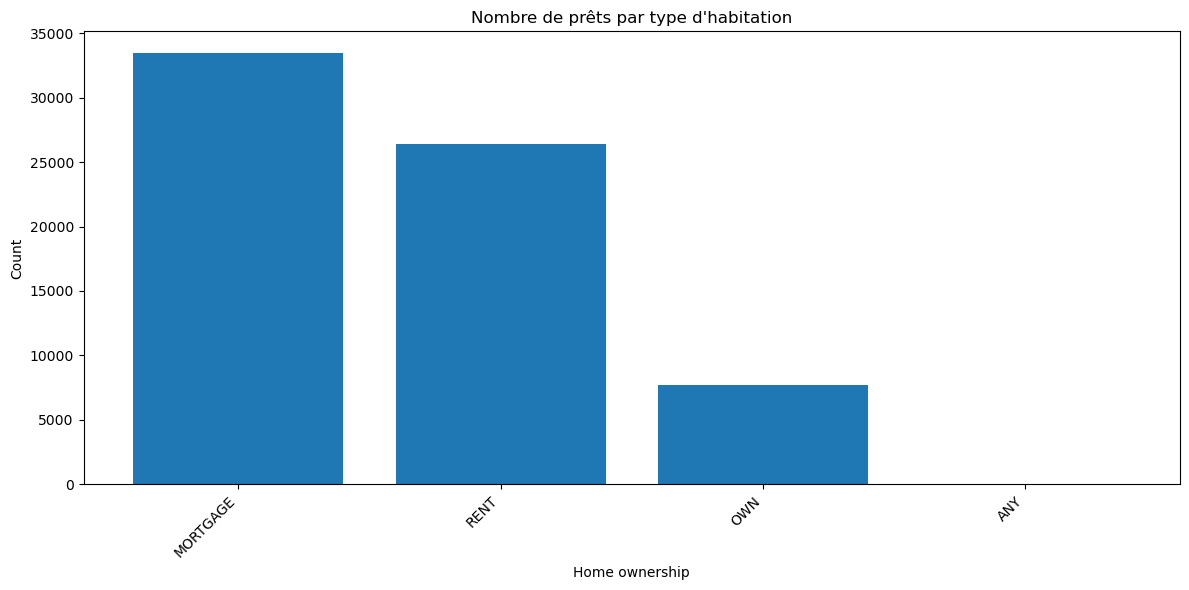

In [101]:
# Convertir le DataFrame Spark en DataFrame Pandas
df_pandas = df_count.toPandas()

# Trier le DataFrame Pandas par ordre décroissant
df_pandas = df_pandas.sort_values(by='count', ascending=False)

# Créer le bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_pandas['home_ownership'], df_pandas['count'])
plt.xlabel('Home ownership')
plt.ylabel('Count')
plt.title("Nombre de prêts par type d'habitation")
plt.xticks(rotation=45, ha='right')

# Afficher le bar chart
plt.tight_layout()
plt.show()

## 'loan_status'

In [102]:
df_count = data.groupBy('loan_status').count()
df_count.orderBy(F.desc("count")).show()

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid|47224|
|       Charged Off|12139|
|           Current| 7737|
|Late (31-120 days)|  313|
|   In Grace Period|  145|
| Late (16-30 days)|   49|
|           Default|    1|
+------------------+-----+



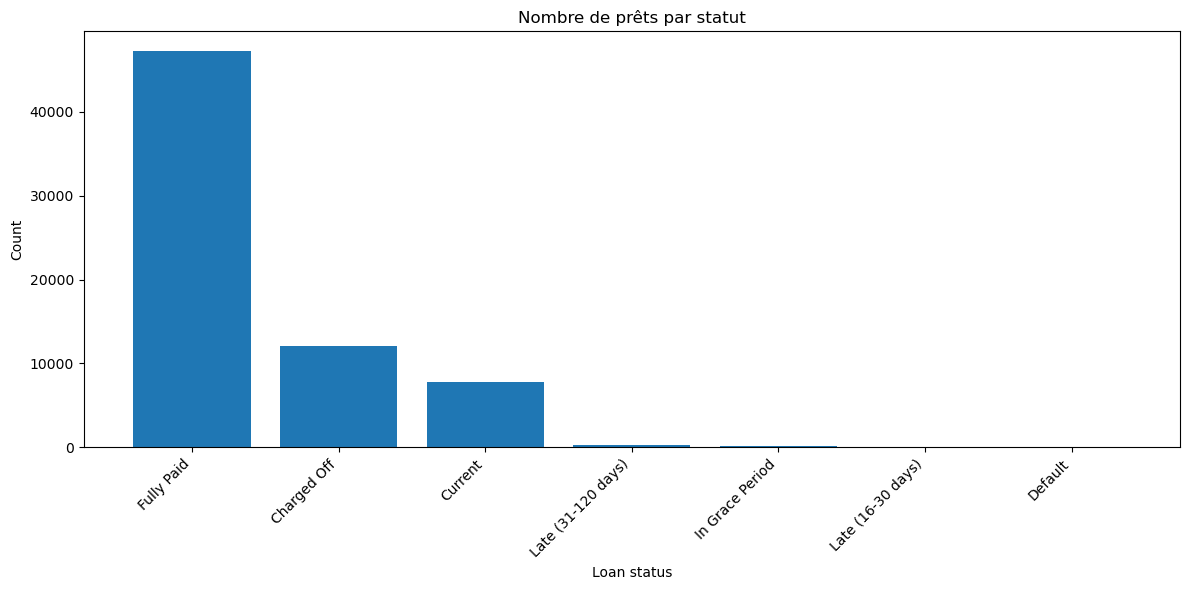

In [103]:
# Convertir le DataFrame Spark en DataFrame Pandas
df_pandas = df_count.toPandas()

# Trier le DataFrame Pandas par ordre décroissant
df_pandas = df_pandas.sort_values(by='count', ascending=False)

# Créer le bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_pandas['loan_status'], df_pandas['count'])
plt.xlabel('Loan status')
plt.ylabel('Count')
plt.title('Nombre de prêts par statut')
plt.xticks(rotation=45, ha='right')

# Afficher le bar chart
plt.tight_layout()
plt.show()

## 'term'

In [106]:
data.groupby('term').count().show()

+----+-----+
|term|count|
+----+-----+
|  60|21668|
|  36|45940|
+----+-----+



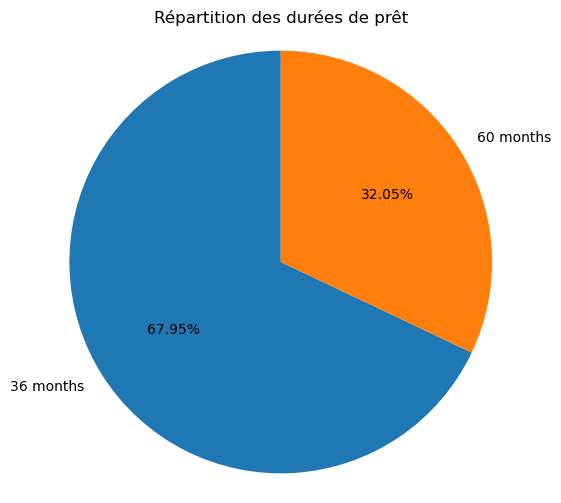

In [104]:
# Données
term_counts = [45940, 21668]
terms = ['36 months', '60 months']

# Créer un pie chart
plt.figure(figsize=(6, 6))
plt.pie(term_counts, labels=terms, autopct='%1.2f%%', startangle=90)
plt.title('Répartition des durées de prêt')
plt.axis('equal')
plt.show()

In [105]:
from pyspark.sql.functions import regexp_replace, col
# Suppression du texte " months" de la colonne "term" et conversion en integer
data = data.withColumn("term", regexp_replace(col("term"), " months", "").cast("int"))
data.show(n=5)

+--------+------------------+----+----------+----------+----------------+-----+--------------+-----+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
|      id|           purpose|term|addr_state|annual_inc|application_type|grade|home_ownership|  dti|delinq_amnt|installment|int_rate|loan_amnt|loan_status|total_rec_late_fee|recoveries|collection_recovery_fee|
+--------+------------------+----+----------+----------+----------------+-----+--------------+-----+-----------+-----------+--------+---------+-----------+------------------+----------+-----------------------+
|68407277|debt_consolidation|  36|        PA|   55000.0|      Individual|    C|      MORTGAGE| 5.91|        0.0|     123.03|   13.99|   3600.0| Fully Paid|               0.0|       0.0|                    0.0|
|68355089|    small_business|  36|        SD|   65000.0|      Individual|    C|      MORTGAGE|16.06|        0.0|     820.28|   11.99|  24700.0| Fully Paid|     

## 'application_type'

In [107]:
data.groupby('application_type').count().orderBy(F.desc("count")).show()

+----------------+-----+
|application_type|count|
+----------------+-----+
|      Individual|67259|
|       Joint App|  349|
+----------------+-----+



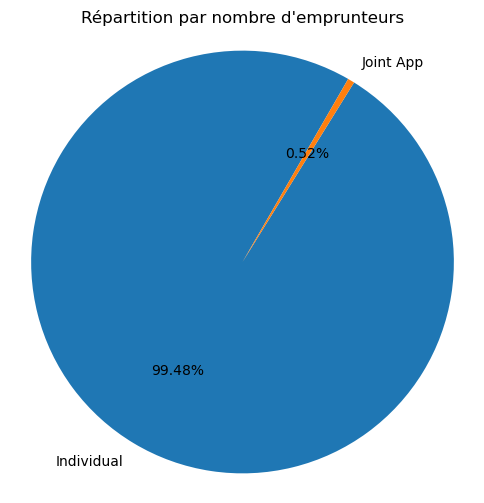

In [108]:
# Données
type_counts = [67259, 349]
types = ['Individual', 'Joint App']

# Créer un pie chart
plt.figure(figsize=(6, 6))
plt.pie(type_counts, labels=types, autopct='%1.2f%%', startangle=60)
plt.title("Répartition par nombre d'emprunteurs")
plt.axis('equal')
plt.show()

## 'grade'

In [109]:
data.groupby('grade').count().orderBy(F.desc("count")).show()

+-----+-----+
|grade|count|
+-----+-----+
|    B|20572|
|    C|19792|
|    A|11708|
|    D| 9185|
|    E| 4730|
|    F| 1333|
|    G|  288|
+-----+-----+



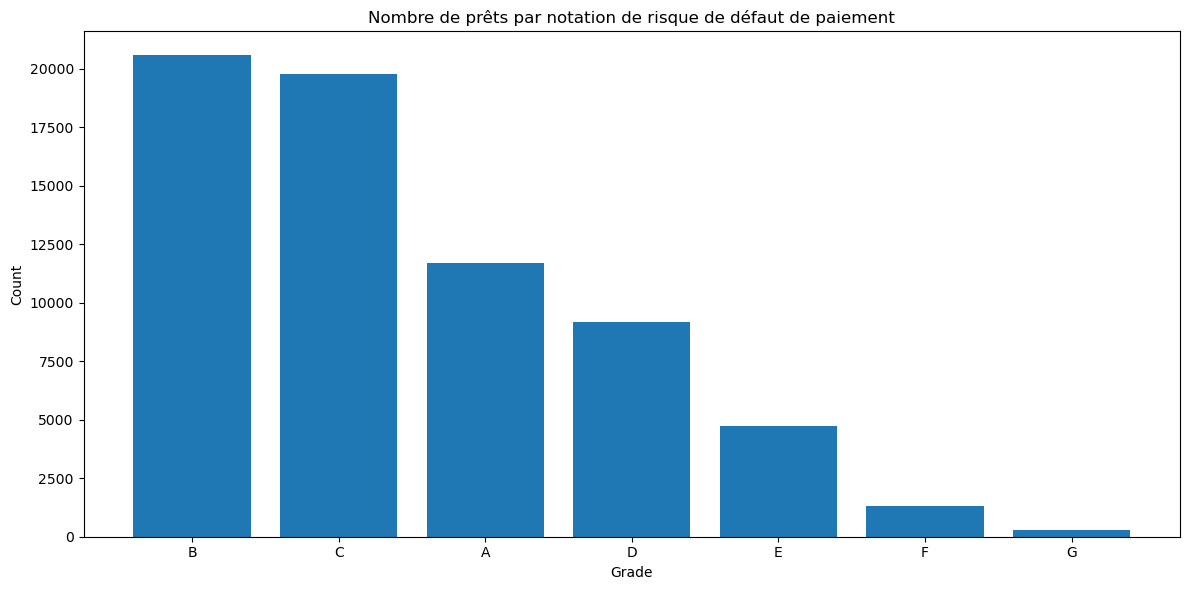

In [110]:
# Convertir le DataFrame Spark en DataFrame Pandas
df_pandas = data.groupby('grade').count().toPandas()

# Trier le DataFrame Pandas par ordre décroissant
df_pandas = df_pandas.sort_values(by='count', ascending=False)

# Créer le bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_pandas['grade'], df_pandas['count'])
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Nombre de prêts par notation de risque de défaut de paiement')

# Afficher le bar chart
plt.tight_layout()
plt.show()

In [111]:
# Create a StringIndexer to convert 'grade' column into numerical indices
grade_indexer = StringIndexer(inputCol="grade", outputCol="grade_index", stringOrderType="alphabetAsc")
df = grade_indexer.fit(data).transform(data)#.drop('grade')
# Afficher la correspondance entre les valeurs originales et les indices numériques
unique_grades = df.select("grade", "grade_index").distinct().orderBy("grade_index")
unique_grades.show()
df = df.drop('grade')

+-----+-----------+
|grade|grade_index|
+-----+-----------+
|    A|        0.0|
|    B|        1.0|
|    C|        2.0|
|    D|        3.0|
|    E|        4.0|
|    F|        5.0|
|    G|        6.0|
+-----+-----------+



# Modification des variables

## One Hot Encoder

In [112]:
def one_hot_encode(df, input_col, output_col=None):
    if output_col is None:
        # Si aucun nom de colonne de sortie n'est spécifié, en générer un automatiquement
        output_col = input_col + '_encoded'

    # Vérifier si la colonne d'entrée existe dans le DataFrame
    if input_col not in df.columns:
        raise ValueError(f"Column '{input_col}' does not exist in the DataFrame.")

    # Indexation de la colonne
    indexer = StringIndexer(inputCol=input_col, outputCol=output_col + '_indexed')
    indexed_df = indexer.fit(df).transform(df)

    # Encodage one-hot de la colonne indexée
    encoder = OneHotEncoder(inputCol=output_col + '_indexed', outputCol=output_col)
    encoded_df = encoder.fit(indexed_df).transform(indexed_df)

    # Suppression de la colonne d'origine et de la colonne indexée
    encoded_df = encoded_df.drop(input_col, output_col + '_indexed')

    return encoded_df

In [113]:
columns_to_encode = ['purpose', 'home_ownership', "addr_state", "application_type"]
for column in columns_to_encode:
    df = one_hot_encode(df, column)

## Conversion vers le type float

In [114]:
columns_to_cast = ['installment',
                   'int_rate',
                   'loan_amnt',
                   'annual_inc',
                   'recoveries',
                   'collection_recovery_fee',
                   'dti',
                   'delinq_amnt',
                   'total_rec_late_fee',
                   'grade_index']

# conversion
for column_name in columns_to_cast:
    df = df.withColumn(column_name, col(column_name).cast('float'))

## Conversion de 'loan_status' en 'target'

In [115]:
df.groupby('loan_status').count().orderBy(F.desc("count")).show()

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid|47224|
|       Charged Off|12139|
|           Current| 7737|
|Late (31-120 days)|  313|
|   In Grace Period|  145|
| Late (16-30 days)|   49|
|           Default|    1|
+------------------+-----+



In [116]:
# Encodage de 'loan_status' => 0 - fully paid, 1 - late, 2 - charged off
df = df.withColumn("target",
                   when(col("loan_status") == "Fully Paid", 0)
                   .when((col("loan_status") == "Late (16-30 days)") | (col("loan_status") == "Late (31-120 days)") | (col("loan_status") == "In Grace Period"), 1)
                   .when((col("loan_status") == "Charged Off") | (col("loan_status") == 'Default'), 2)
                   .otherwise(None)).drop("loan_status")
df = df.filter(df.target.isNotNull())

In [117]:
df.groupby('target').count().orderBy(F.desc("count")).show()

+------+-----+
|target|count|
+------+-----+
|     0|47224|
|     2|12140|
|     1|  507|
+------+-----+



In [118]:
data_dtypes = df.dtypes
df_dtypes = pd.DataFrame(data_dtypes, columns=["Colonne", "Type"])
print(df_dtypes)

                     Colonne    Type
0                         id     int
1                       term     int
2                 annual_inc   float
3                        dti   float
4                delinq_amnt   float
5                installment   float
6                   int_rate   float
7                  loan_amnt   float
8         total_rec_late_fee   float
9                 recoveries   float
10   collection_recovery_fee   float
11               grade_index   float
12           purpose_encoded  vector
13    home_ownership_encoded  vector
14        addr_state_encoded  vector
15  application_type_encoded  vector
16                    target     int


### Barcharts

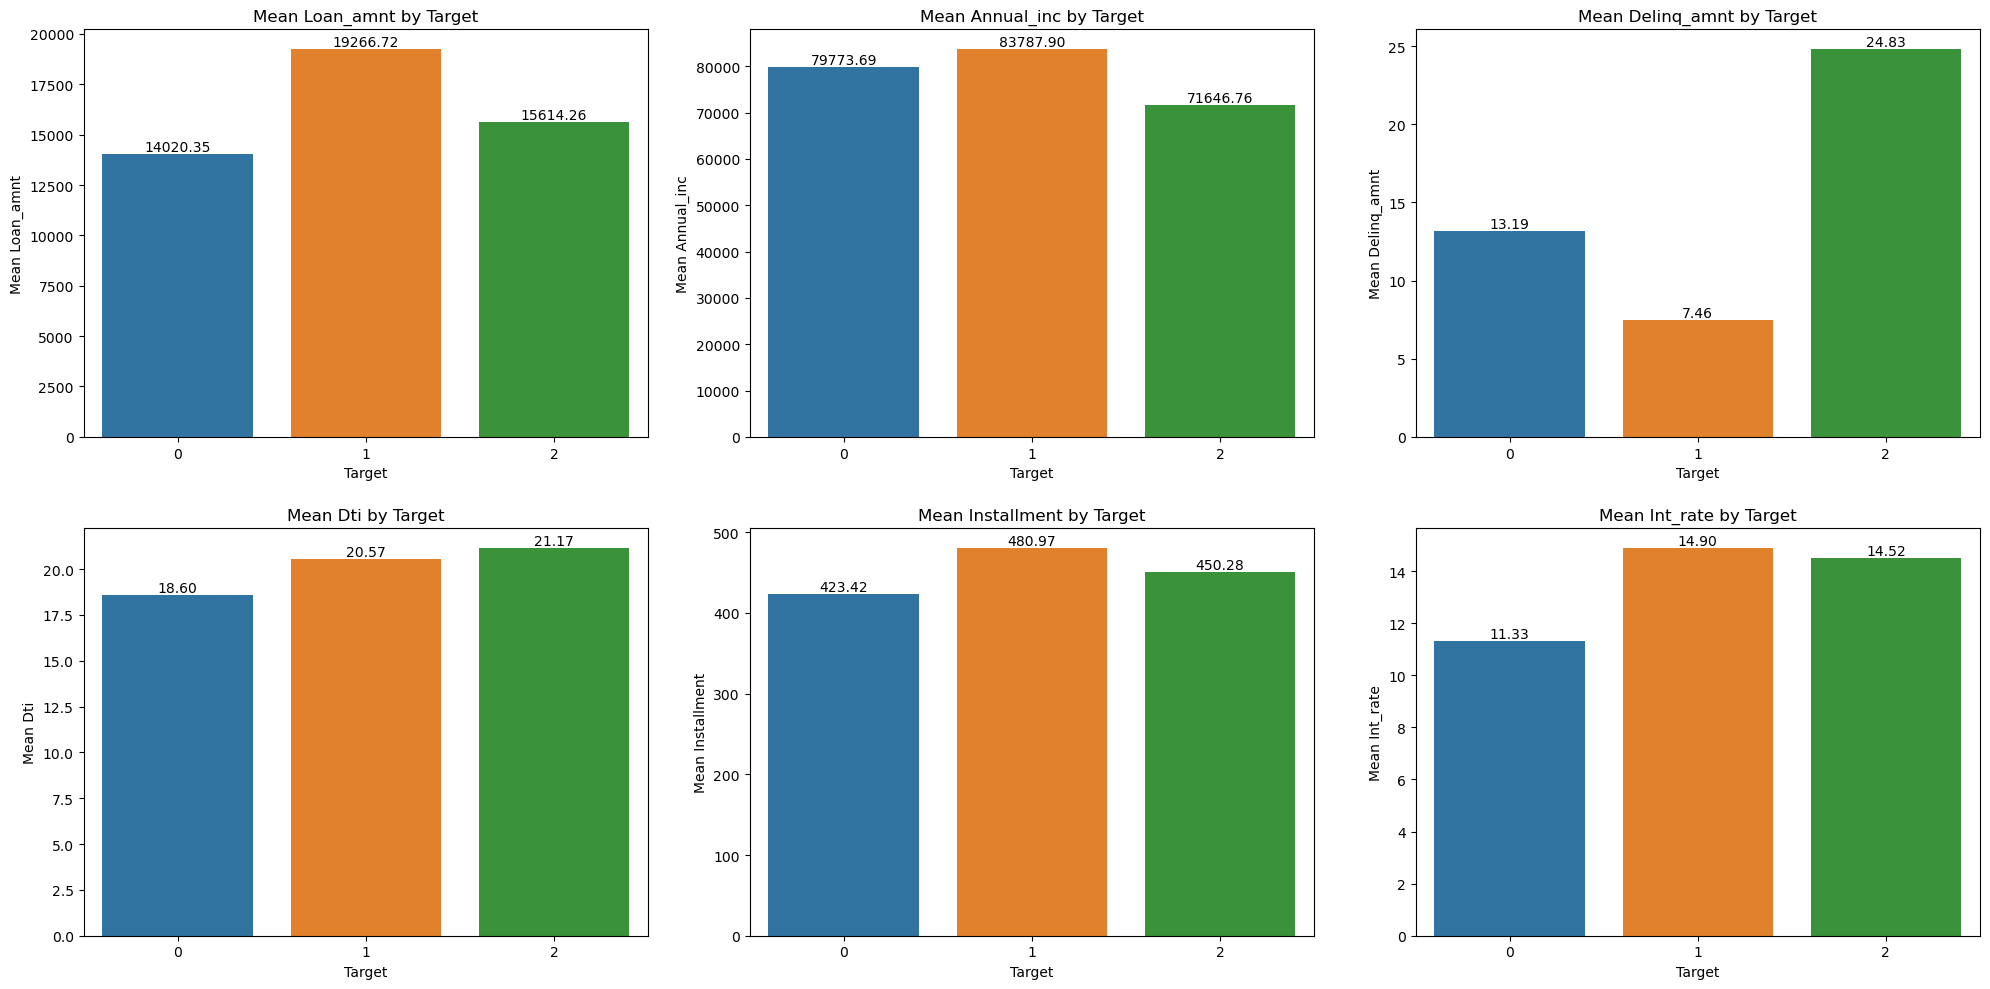

In [119]:
# Rappel : Fully Paid => 0, Late => 1, Charged off => 2
columns_to_plot = ["loan_amnt", "annual_inc", "delinq_amnt", "dti", "installment", "int_rate"]
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Fonction pour ajouter les montants aux graphiques
def add_recall_text(ax, target, recall):
    ax.text(target, recall, f"{recall:.2f}", ha="center", va="bottom", fontsize=10)

# Création des barcharts
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    mean_by_target = df.groupby("target").mean(column).toPandas()
    sns.barplot(x="target", y=f"avg({column})", data=mean_by_target, ax=ax)
    ax.set_title(f"Mean {column.capitalize()} by Target")
    ax.set_xlabel("Target")
    ax.set_ylabel(f"Mean {column.capitalize()}")

    # Ajoutez le montant à chaque barre du graphique
    targets = mean_by_target["target"].tolist()
    recalls = mean_by_target[f"avg({column})"].tolist()
    for target, recall in zip(targets, recalls):
        add_recall_text(ax, target, recall)
plt.tight_layout(w_pad=2, h_pad=2)
plt.show()

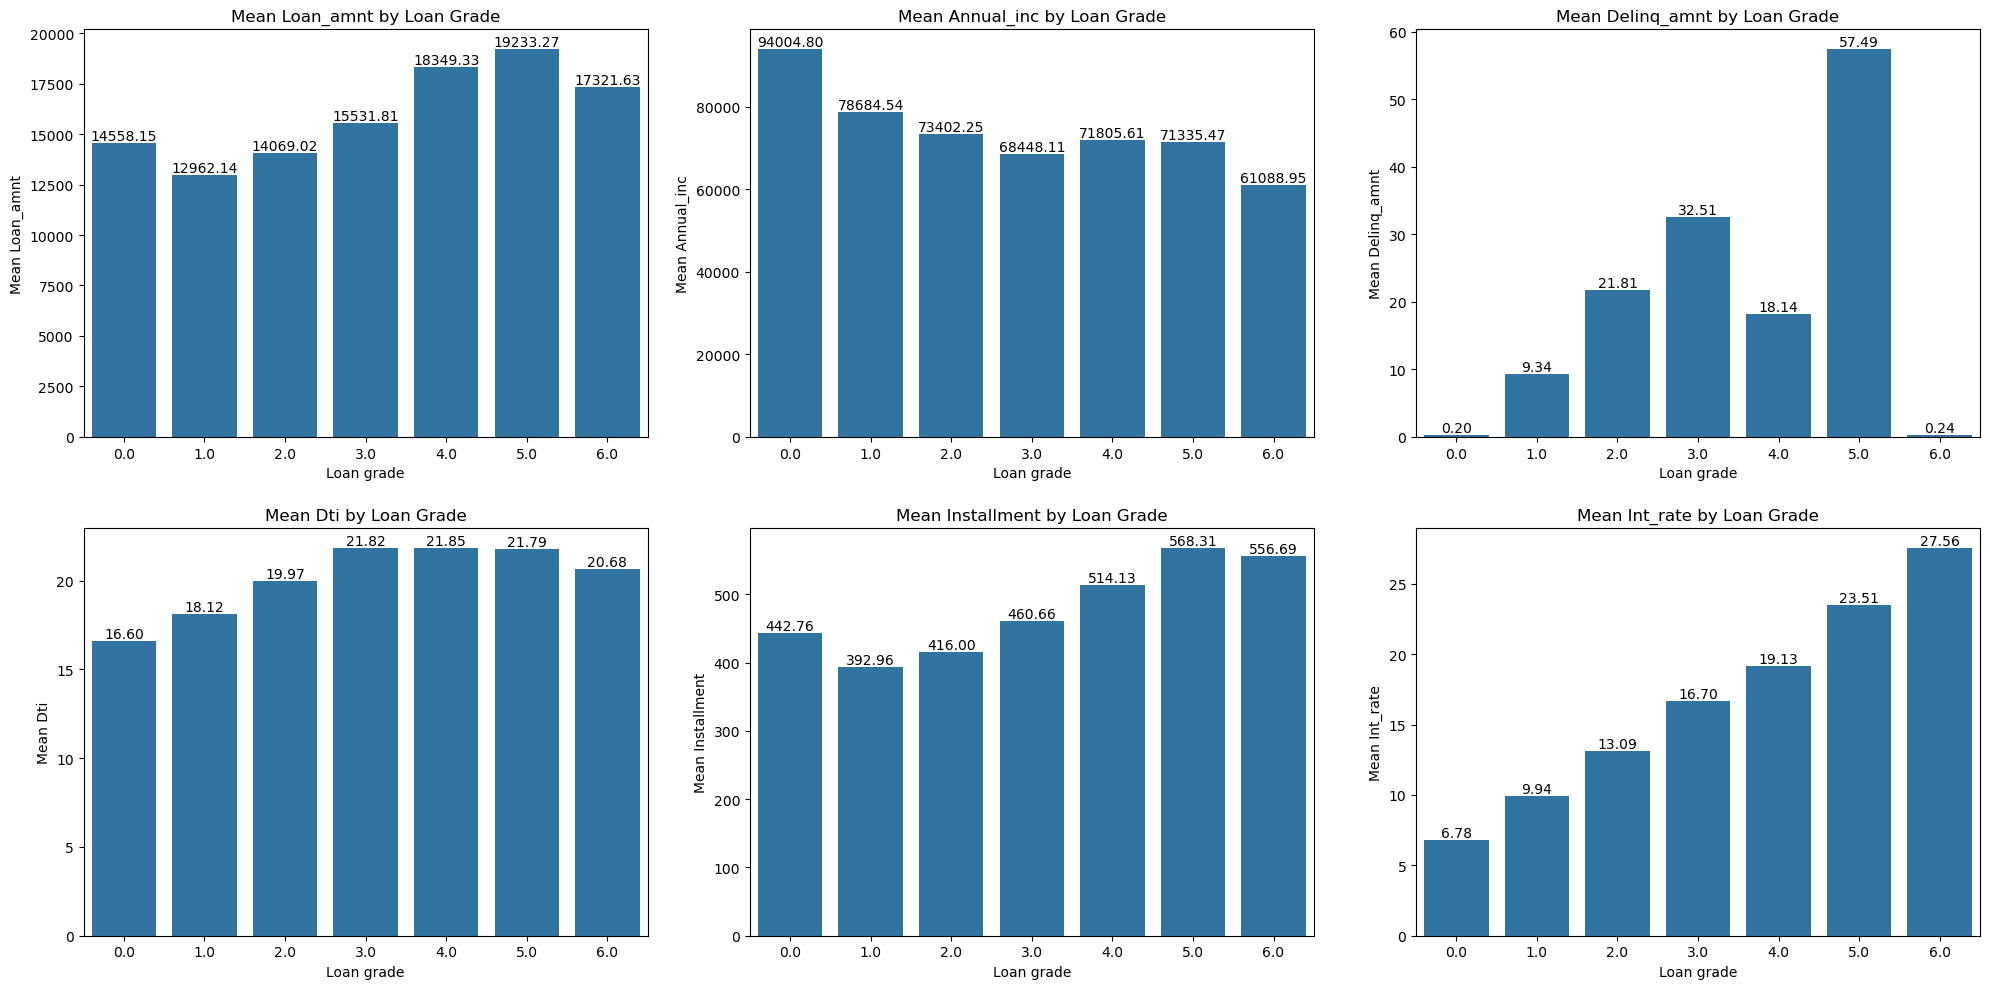

In [120]:
# Rappel : Fully Paid => 0, Late => 1, Charged off => 2
columns_to_plot = ["loan_amnt", "annual_inc", "delinq_amnt", "dti", "installment", "int_rate"]
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Couleur bleue
bar_color = "#1f77b4"

# Fonction pour ajouter les montants aux graphiques
def add_recall_text(ax, target, recall):
    ax.text(target, recall, f"{recall:.2f}", ha="center", va="bottom", fontsize=10)

# Création des barcharts
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    mean_by_target = df.groupby("grade_index").mean(column).toPandas()
    sns.barplot(x="grade_index", y=f"avg({column})", data=mean_by_target, ax=ax, color=bar_color)
    ax.set_title(f"Mean {column.capitalize()} by Loan Grade")
    ax.set_xlabel("Loan grade")
    ax.set_ylabel(f"Mean {column.capitalize()}")

    # Ajoutez le montant à chaque barre du graphique
    targets = mean_by_target["grade_index"].tolist()
    recalls = mean_by_target[f"avg({column})"].tolist()
    for target, recall in zip(targets, recalls):
        add_recall_text(ax, target, recall)
        
plt.tight_layout(w_pad=2, h_pad=2)
plt.show()

# Regression linéaire

## Variables numériques

In [44]:
# Sélectionnez uniquement les colonnes de type float
num_columns = [col_name for col_name, col_type in df.dtypes if col_type in ['float', 'int']]

# Utilisez la méthode select pour ne conserver que les colonnes de type float
df_num = df.select(num_columns)
df_num.show(n=1)

+--------+----+----------+----+-----------+-----------+--------+---------+------------------+----------+-----------------------+-----------+------+
|      id|term|annual_inc| dti|delinq_amnt|installment|int_rate|loan_amnt|total_rec_late_fee|recoveries|collection_recovery_fee|grade_index|target|
+--------+----+----------+----+-----------+-----------+--------+---------+------------------+----------+-----------------------+-----------+------+
|68407277|  36|   55000.0|5.91|        0.0|     123.03|   13.99|   3600.0|               0.0|       0.0|                    0.0|        2.0|     0|
+--------+----+----------+----+-----------+-----------+--------+---------+------------------+----------+-----------------------+-----------+------+
only showing top 1 row



## Vérification de la significativité des variables

In [45]:
df_signif = df_num.toPandas()

# Données
X = df_signif[['annual_inc', 'dti', 'int_rate', 'loan_amnt', 'installment', 'term']] # On veut prédire le risque crédit des nouveaux clients
y = df_signif['grade_index']

# Estimation de la régression linéaire avec scikit-learn
model = LinearRegression()
model.fit(X, y)

# Calcul des p-values
n = len(y)
p = len(X.columns)
y_pred = model.predict(X)
sse = np.sum((y - y_pred) ** 2) / (n - p - 1)
se = np.sqrt(np.diag(np.linalg.inv(np.dot(X.T, X)) * sse))
t_values = model.coef_ / se
p_values = 2 * (1 - stats.norm.cdf(np.abs(t_values)))

# Création d'un DataFrame pour afficher les résultats
results = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_, 'P-Value': p_values})

# Trier les résultats par ordre décroissant de l'absolu des coefficients
results['Absolute Coefficient'] = np.abs(results['Coefficient'])
results = results[['Variable', 'Absolute Coefficient', 'Coefficient', 'P-Value']]
results = results.sort_values(by='Absolute Coefficient', ascending=False)
print(results)

      Variable  Absolute Coefficient   Coefficient   P-Value
2     int_rate          2.885765e-01  2.885765e-01  0.000000
5         term          2.274185e-03  2.274185e-03  0.000000
1          dti          2.042456e-04 -2.042456e-04  0.107254
4  installment          2.898274e-05  2.898274e-05  0.168080
3    loan_amnt          1.384047e-06 -1.384047e-06  0.040613
0   annual_inc          4.518046e-09 -4.518046e-09  0.744225


**=> On remarque que certaines variables ne sont pas significatives (p-value > 0.05), nous gardons `loan_amnt`, `int_rate` et `dti`, nous verrons ci-dessous que cette combinaison permet une absence de multicolinéarité**

## VIF

In [46]:
df_num_pandas = df_num.toPandas()

In [47]:
elements_to_drop = ['id', 'target', 'recoveries', 'delinq_amnt', 'total_rec_late_fee', 'collection_recovery_fee', 'grade_index', 'loan_amnt', 'installment', 'term', 'annual_inc']
#ma_liste = [x for x in df_num_pandas if x not in elements_to_drop]
ma_liste = ['loan_amnt', 'dti', 'int_rate']
print(ma_liste)

['loan_amnt', 'dti', 'int_rate']


    Variable       VIF
0  loan_amnt  3.336777
1        dti  4.188011
2   int_rate  5.604972


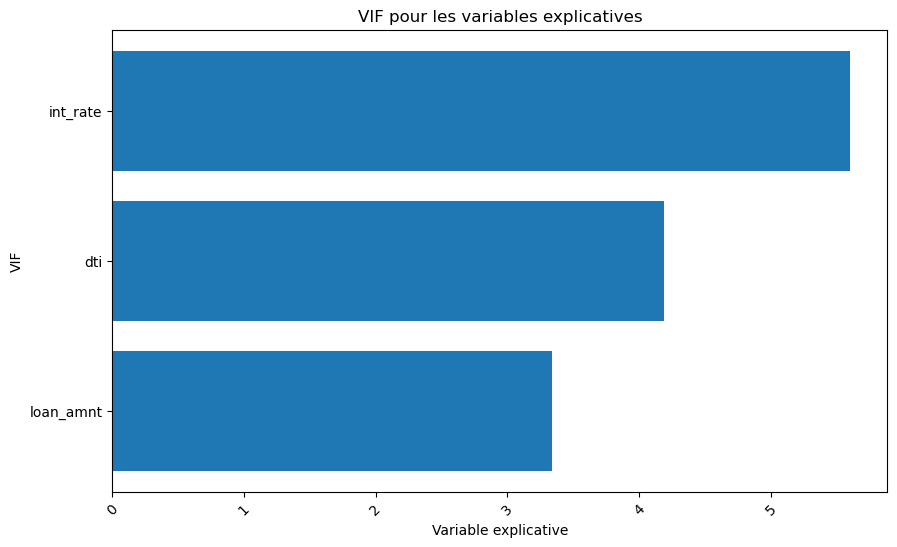

In [48]:
# Calcul du VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = ma_liste
vif_data["VIF"] = [variance_inflation_factor(df_num_pandas[ma_liste].values, i) for i in range(len(ma_liste))]
print(vif_data)

# Tri VIF par ordre décroissant
vif_data = vif_data.sort_values(by="VIF", ascending=True)

# Afficher les résultats VIF sous forme de graphique
plt.figure(figsize=(10, 6))
plt.barh(vif_data["Variable"], vif_data["VIF"])
plt.xlabel("Variable explicative")
plt.ylabel("VIF")
plt.title("VIF pour les variables explicatives")
plt.xticks(rotation=45)
plt.show()

## VectorAssembler

In [49]:
feature_cols = ma_liste
target = ['grade_index']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_to_scale")
df_assembled = assembler.transform(df_num)
df_assembled.select('features_to_scale', 'target').show(5)

+--------------------+------+
|   features_to_scale|target|
+--------------------+------+
|[3600.0,5.9099998...|     0|
|[24700.0,16.05999...|     0|
|[20000.0,10.77999...|     0|
|[10400.0,25.37000...|     0|
|[11950.0,10.19999...|     0|
+--------------------+------+
only showing top 5 rows



## Standardisation

In [50]:
def scale_features(input_df: DataFrame, input_col: str, output_col: str = None) -> DataFrame:

    # Vérifier si la colonne d'entrée existe dans le DataFrame
    if input_col not in input_df.columns:
        raise ValueError(f"Column '{input_col}' does not exist in the input DataFrame.")

    # Utiliser un nom de colonne de sortie par défaut si aucun n'est spécifié
    if output_col is None:
        output_col = input_col + '_scaled'

    # Appliquer le scaler
    scaler = MinMaxScaler(inputCol=input_col, outputCol=output_col)
    scaler_model = scaler.fit(input_df)
    scaled_df = scaler_model.transform(input_df)
    
    return scaled_df

In [51]:
train_data, temp_data = df_assembled.randomSplit([0.8, 0.2], seed=1)
test_data, val_data = temp_data.randomSplit([0.5, 0.5], seed=1)

In [52]:
train_data = scale_features(train_data, "features_to_scale", "features")
val_data = scale_features(val_data, "features_to_scale", "features")
test_data = scale_features(test_data, "features_to_scale", "features")

## Modèle

In [53]:
from pyspark.ml.regression import LinearRegression

In [54]:
# Entraînement du modèle
lr = LinearRegression(featuresCol='features', labelCol='grade_index')
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

# Évaluer la performance du modèle avec différentes métriques
evaluator_r2 = RegressionEvaluator(labelCol="grade_index", predictionCol="prediction", metricName="r2")
evaluator = RegressionEvaluator(labelCol="grade_index", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="grade_index", predictionCol="prediction", metricName="mae")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

def mean_absolute_percentage_error(predictions, labelCol="grade_index", predictionCol="prediction"):
    mape = predictions.withColumn("absolute_percentage_error", (pyspark_abs(col(labelCol) - col(predictionCol)) / col(labelCol)) * 100)
    mape = mape.select(mean("absolute_percentage_error")).collect()[0][0]
    return mape

def root_mean_squared_percentage_error(predictions, labelCol="grade_index", predictionCol="prediction"):
    rmspe = predictions.withColumn("percentage_error", (col(labelCol) - col(predictionCol)) / col(labelCol))
    rmspe = rmspe.withColumn("squared_percentage_error", rmspe["percentage_error"]**2)
    rmspe = rmspe.select(sqrt(mean("squared_percentage_error")) * 100).collect()[0][0]
    return rmspe

mape = mean_absolute_percentage_error(predictions)
rmspe = root_mean_squared_percentage_error(predictions)

print("Coefficient de détermination (R2):", r2)
print("Root Mean Squared Error (RMSE):", rmse)
print("Erreur absolue moyenne (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Percentage Error (RMSPE):", rmspe)

Coefficient de détermination (R2): 0.9374319822653281
Root Mean Squared Error (RMSE): 0.31457069007946586
Erreur absolue moyenne (MAE): 0.2584544685512315
Mean Absolute Percentage Error (MAPE): 16.298928199470414
Root Mean Squared Percentage Error (RMSPE): 21.49715558437354


1. **Coefficient de détermination (R2)** : Le coefficient de détermination, également appelé R-squared (R2), mesure la proportion de la variance totale de la variable dépendante expliquée par le modèle. Un R2 de 0.9374 signifie que le modèle explique environ 93,74 % de la variance dans la variable "grade_index". Un R2 élevé est généralement souhaitable, car il indique que le modèle s'ajuste bien aux données.

2. **Root Mean Squared Error (RMSE)** : Le RMSE est une mesure de l'erreur globale du modèle. Il représente la racine carrée de la moyenne des carrés des écarts entre les valeurs prédites par le modèle et les valeurs réelles. Un RMSE de 0.3146 indique en moyenne à quel point les prédictions du modèle sont éloignées des valeurs réelles. Plus le RMSE est faible, meilleure est la performance du modèle.

3. **Erreur absolue moyenne (MAE)** : Le MAE mesure l'erreur moyenne absolue entre les prédictions du modèle et les valeurs réelles. Un MAE de 0.2585 signifie que, en moyenne, les prédictions du modèle ont une erreur absolue d'environ 0.2585 unités par rapport aux vraies valeurs.

4. **Mean Absolute Percentage Error (MAPE)** : Le MAPE mesure l'erreur relative moyenne en pourcentage entre les prédictions du modèle et les valeurs réelles. Un MAPE de 16.30 % indique que, en moyenne, les prédictions du modèle ont une erreur relative d'environ 16.30 % par rapport aux vraies valeurs. Le MAPE est utile pour évaluer l'erreur en termes de pourcentage.

5. **Root Mean Squared Percentage Error (RMSPE)** : Le RMSPE est similaire au RMSE, mais il mesure l'erreur en pourcentage plutôt qu'en unités absolues. Un RMSPE de 21.50 % signifie que, en moyenne, les prédictions du modèle ont une erreur en pourcentage d'environ 21.50 % par rapport aux vraies valeurs.

En résumé, un R2 élevé et des valeurs de RMSE, MAE, MAPE et RMSPE faibles indiquent une bonne performance du modèle. Cependant, il est important de considérer ces métriques dans le contexte du domaine d'application spécifique pour déterminer si le modèle répond aux besoins.

***=> Ces métriques globalement faibles et le R2 élevé suggèrent que ce modèle de régression linéaire semble performant, il est capable de bien prédire la variable "grade_index" en fonction des caractéristiques fournies.***

# Classification

## Sous-échantillonnage
On applique le sous-échantillonnage sur la Classe 0 pour obtenir un jeu de données plus équilibré.
<br>
Cela peut contribuer à améliorer les performances des modèles d'apprentissage automatique, car ils seront entraînés sur un jeu de données plus représentatif.

In [55]:
# Conserver 30% des exemples de la classe majoritaire
df = df.drop('id')
df_downsampled = df.filter(col("target") == 0).sampleBy("target", fractions={0: 0.3}).unionAll(df.filter(col("target") != 0))
df_downsampled = df_downsampled.na.drop()
df_downsampled.groupby('target').count().orderBy(F.desc("count")).show()

+------+-----+
|target|count|
+------+-----+
|     0|14307|
|     2|12140|
|     1|  507|
+------+-----+



In [56]:
df_downsampled.show(n=1)

+----+----------+-----+-----------+-----------+--------+---------+------------------+----------+-----------------------+-----------+---------------+----------------------+------------------+------------------------+------+
|term|annual_inc|  dti|delinq_amnt|installment|int_rate|loan_amnt|total_rec_late_fee|recoveries|collection_recovery_fee|grade_index|purpose_encoded|home_ownership_encoded|addr_state_encoded|application_type_encoded|target|
+----+----------+-----+-----------+-----------+--------+---------+------------------+----------+-----------------------+-----------+---------------+----------------------+------------------+------------------------+------+
|  60|   63000.0|10.78|        0.0|     432.66|   10.78|  20000.0|               0.0|       0.0|                    0.0|        1.0| (11,[2],[1.0])|         (3,[0],[1.0])|    (48,[4],[1.0])|               (1,[],[])|     0|
+----+----------+-----+-----------+-----------+--------+---------+------------------+----------+------------

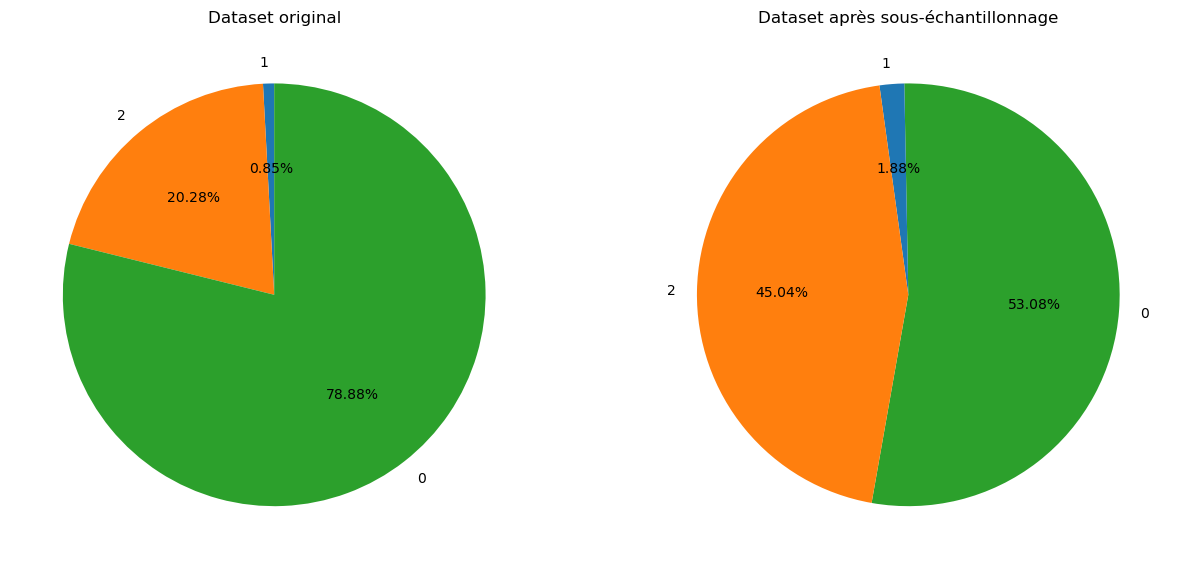

In [57]:
# Données du dataset original
loan_status_count_original = df.groupby('target').count().toPandas()

# Données du dataset sous-échantillonné
loan_status_count_downsampled = df_downsampled.groupby('target').count().toPandas()

# Dictionnaire de correspondance des couleurs aux catégories
categories = loan_status_count_original['target'].unique()
category_colors = {category: sns.color_palette()[i] for i, category in enumerate(categories)}

# Création de la figure
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Piechart pour le dataset original
original_colors = [category_colors[category] for category in loan_status_count_original['target']]
axs[0].pie(loan_status_count_original['count'], labels=loan_status_count_original['target'], autopct='%1.2f%%', startangle=90, colors=original_colors)
axs[0].set_title('Dataset original')

# Piechart pour le dataset sous-échantillonné
downsampled_colors = [category_colors[category] for category in loan_status_count_downsampled['target']]
axs[1].pie(loan_status_count_downsampled['count'], labels=loan_status_count_downsampled['target'], autopct='%1.2f%%', startangle=260, colors=downsampled_colors)
axs[1].set_title('Dataset après sous-échantillonnage')

plt.show()

## VectorAssembler

In [58]:
all_columns = df_downsampled.columns
feature_cols = [col_name for col_name in all_columns if col_name != 'target']
target = ['target']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_to_scale")
df_downsampled = assembler.transform(df_downsampled)
df_downsampled.select('features_to_scale', 'target').show(5)

+--------------------+------+
|   features_to_scale|target|
+--------------------+------+
|(74,[0,1,2,4,5,6,...|     0|
|(74,[0,1,2,4,5,6,...|     0|
|(74,[0,1,2,4,5,6,...|     0|
|(74,[0,1,2,4,5,6,...|     0|
|(74,[0,1,2,4,5,6,...|     0|
+--------------------+------+
only showing top 5 rows



## Standardisation

In [59]:
train_data, temp_data = df_downsampled.randomSplit([0.8, 0.2], seed=1)
test_data, val_data = temp_data.randomSplit([0.5, 0.5], seed=1)

In [60]:
train_data = scale_features(train_data, "features_to_scale", "features")
val_data = scale_features(val_data, "features_to_scale", "features")
test_data = scale_features(test_data, "features_to_scale", "features")

## Modèles

In [61]:
def evaluate_model(model, model_name, train_data, validation_data, test_data):
    model = model.fit(train_data)

    predictions_train = model.transform(train_data)
    predictions_validation = model.transform(validation_data)
    predictions_test = model.transform(test_data)

    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
    f1_evaluator = MulticlassClassificationEvaluator(metricName="weightedFMeasure", labelCol="target")

    accuracy_train = evaluator_accuracy.evaluate(predictions_train)
    f1_score_train = f1_evaluator.evaluate(predictions_train)

    accuracy_validation = evaluator_accuracy.evaluate(predictions_validation)
    f1_score_validation = f1_evaluator.evaluate(predictions_validation)

    accuracy_test = evaluator_accuracy.evaluate(predictions_test)
    f1_score_test = f1_evaluator.evaluate(predictions_test)

    results_df = pd.DataFrame({
    "Model": [model_name],
    "Accuracy (Train)": [round(accuracy_train, 3)],
    "F1 Score (Train)": [round(f1_score_train, 3)],
    "Accuracy (Validation)": [round(accuracy_validation, 3)],
    "F1 Score (Validation)": [round(f1_score_validation, 3)],
    "Accuracy (Test)": [round(accuracy_test, 3)],
    "F1 Score (Test)": [round(f1_score_test, 3)],
    })

    return results_df

### Logistic Regression

In [62]:
lr = LogisticRegression(featuresCol='features', labelCol='target')
results_df_lr = evaluate_model(lr, 'LogisticRegression', train_data, val_data, test_data)

### Random Forest

In [63]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
results_df_rf = evaluate_model(rf, 'Random Forest', train_data, val_data, test_data)

### Results

In [64]:
final_results_df = pd.concat([results_df_lr, results_df_rf], ignore_index=True)
final_results_df

,Model,Accuracy (Train),F1 Score (Train),Accuracy (Validation),F1 Score (Validation),Accuracy (Test),F1 Score (Test)
0,LogisticRegression,0.843,0.834,0.809,0.804,0.842,0.833
1,Random Forest,0.836,0.824,0.842,0.830,0.840,0.828


1. **Logistic Regression** :
   - **Accuracy (Train)** : Le modèle de régression logistique atteint une précision de 84,5 % sur l'ensemble d'entraînement. Cela signifie qu'il prédit correctement la classe cible dans 84,5 % des cas sur cet ensemble.
   - **F1 Score (Train)** : Le F1-score est de 0,834 sur l'ensemble d'entraînement. Il mesure la précision et le rappel du modèle. Un F1-score élevé est souhaitable, ce qui indique une bonne performance en termes d'équilibre entre la précision et le rappel.
   - **Accuracy (Validation)** : La précision sur l'ensemble de validation est de 80,9 %. Ce qui suggère que le modèle se comporte bien lorsqu'il est confronté à de nouvelles données qu'il n'a pas vu pendant l'entraînement.
   - **F1 Score (Validation)** : Le F1-score sur l'ensemble de validation est de 0,804, ce qui est considéré comme un bon score.
   - **Accuracy (Test)** : La précision sur l'ensemble de test est de 84,2 %. Ce qui est cohérent avec les performances sur les autres ensembles, le modèle ne semble pas sujet aux surajustement.
   - **F1 Score (Test)** : Le F1-score sur l'ensemble de test est de 0,833. Cela indique que le modèle de régression logistique a des bonnes performances en termes de précision et de rappel sur l'ensemble de test. Il généralise bien sur de nouvelles données.
<br><br>
2. **Random Forest** :
   - **Accuracy (Train)** : Le modèle Random Forest atteint une précision de 83,6 % sur l'ensemble d'entraînement, ce qui est similaire à la régression logistique, quoique légèrement inférieur.
   - **F1 Score (Train)** : Le F1-score sur l'ensemble d'entraînement est de 0,824, ce qui est également élevé, tout en étant légèrement inférieur à la régression logitique.
   - **Accuracy (Validation)** : La précision sur l'ensemble de validation est élevée à 84,2 %. Cela signifie que le modèle Random Forest généralise bien sur cet ensemble et fait légèrement mieux que la régression logistique.
   - **F1 Score (Validation)** : Le F1-score sur l'ensemble de validation est de 0,83, montrant de bonnes performances en termes de précision et de rappel, toujours légèrement supérieurs à la régression logistique.
   - **Accuracy (Test)** : La précision sur l'ensemble de test est de 84 %, similaire à la régression logistique.
   - **F1 Score (Test)** : Le F1-score sur l'ensemble de test est de 0,828, ce qui est légèrement plus bas que celui de la régression logistique, mais indique quand même une bonne performance en termes de précision et de rappel sur l'ensemble de test.

*=> En résumé, les deux modèles sont très proches en terme de performance globale. La forêt aléatoire généralise mieux sur les ensembles de validation, tandis que la régression logistique fait mieux sur les ensembles d'entraînement et de test. Cependant, l'interprétation finale dépend également du contexte spécifique du problème, de la complexité et de l'interprétabilité du modèle, ainsi que du temps d'entraînement du modèle et des ressources computationnelles. La régression logistique, par exemple, offre un bon équilibre entre simplicité et performance, ce qui en fait un choix approprié lorsque l'interprétabilité est cruciale.*

# Arrêt de Spark

In [66]:
spark.stop()